In [5]:
] activate ..

  Activating project at `/Volumes/Working/Documents/Harvard/Physics/Research/EHT/LimbBrightening`


In [6]:
using Krang
using CairoMakie
using IJulia
using Unitful
using UnitfulAstro
using StaticArrays
include(joinpath((@__DIR__), "modifiers.jl"))
include(joinpath((@__DIR__), "thermal_power_law_emissivity.jl"))


    Loaded Constants
    ----------------
    -   c : Speed of light (2.998e8 m s⁻¹)
    -   G : Gravitational constant (6.6743e-11 m³ kg⁻¹ s⁻²)
    -   me : Electron mass (9.1093837015e-31 kg)
    -   mp : Proton mass (1.67262192369e-27 kg)
    -   e : Elementary charge (1.602176634e-19 A s)
    -   kB : Boltzmann constant (1.380649e-23 kg m² K⁻¹ s⁻²)
    -   h : Planck constant (6.62607015e-34 kg m² s⁻¹)
    -   rg : Schwarzschild radius (9.597579840863447e12 m)
    -   ke : Coulomb constant (8.988e9 kg m³ A⁻² s⁻⁴)



In [7]:
struct ThermalSynchrotron{N,T} <: Krang.AbstractMaterial 
    magnetic_field0::SVector{3,T}
    fluid_velocity::SVector{3,T}
    p_dens::T
    p_temp::T
    p_b::T
    n_th0::T
    t_e0::T
    rb::T
    subimgs::NTuple{N,Int}
    function ThermalSynchrotron(
        magnetic_fieldx::T,
        magnetic_fieldy::T,
        magnetic_fieldz::T,
        fluid_speed::T,
        fluid_inclination_angle::T,
        fluid_azimuthal_angle::T,
        p_dens::T,
        p_temp::T,
        p_b::T,
        n_th0::T,
        t_e0::T,
        r_b::T,
        subimgs::NTuple{N,Int},
    ) where {N,T}
        new{N,T}(
            SVector(magnetic_fieldx, magnetic_fieldy, magnetic_fieldz),
            SVector(fluid_speed, fluid_inclination_angle, fluid_azimuthal_angle),
            p_dens,
            p_temp,
            p_b,
            n_th0,
            t_e0,
            r_b,
            subimgs,
        )
    end
end


In [14]:
function thermalSynchrotronEmissivity(
    metric::Kerr{T},
    α,
    β,
    ri,
    θs,
    θo,
    temperature::typeof(1.0u"K"),
    n_th::typeof(1.0*u"m^-3"),
    ν::typeof(1.0u"Hz"),
    magnetic_field::SVector{3,T},
    βfluid::SVector{3,T},
    νr::Bool,
    θsign::Bool,
) where {T}

    βv = βfluid[1]
    θz = βfluid[2]
    ϕz = βfluid[3]

    ηtemp = Krang.η(metric, α, β, θo)
    λtemp = Krang.λ(metric, α, θo)

    # photon co-momentum in BL coordinates
    curr_p_bl_d = p_bl_d(metric, ri, θs, ηtemp, λtemp, νr, θsign)
    curr_p_bl_u = metric_uu(metric, ri, θs) * curr_p_bl_d
    p_zamo_u = jac_zamo_u_bl_d(metric, ri, θs) * curr_p_bl_u
    p_fluid_u = jac_fluid_u_zamo_d(metric, βv, θz, ϕz) * p_zamo_u
    magnetic_fieldx, magnetic_fieldy, magnetic_fieldz = magnetic_field
    # normalized photon momentum
    _, p_fluid_ux, p_fluid_uy, p_fluid_uz = p_fluid_u ./ p_fluid_u[1]
    vec = @SVector[
        p_fluid_uy * magnetic_fieldz - p_fluid_uz * magnetic_fieldy,
        p_fluid_uz * magnetic_fieldx - p_fluid_ux * magnetic_fieldz,
        p_fluid_ux * magnetic_fieldy - p_fluid_uy * magnetic_fieldx,
    ]
    bsinθb = √sum(vec .* vec) + eps(T)


    θe = theta_e_func(temperature) |> upreferred
    νc = nu_c_func(bsinθb*Unitful.Gauss, θe)
    redshift = inv(p_fluid_u[1])
    lp = abs(p_fluid_u[1] / p_fluid_u[4])
    return upreferred(c*ke*n_th*e^2*ν/(2√3*c*θe^2)*synchrotron_func_I(ν/νc)), redshift, lp
end
function (mat::ThermalSynchrotron)(pix, intersection)
    (;rs, θs, νr, νθ) = intersection
    α, β = Krang.screen_coordinate(pix)
    θo = Krang.inclination(pix)
    nth = nth_func(rs, mat.n_th0, mat.rb, mat.p_dens)
    temperature = te_func(rs, mat.t_e0, mat.rb, mat.p_temp)
    b_mag0 = hypot(mat.magnetic_field0...)
    magnetic_field = b_func_power(rs, b_mag0, mat.rb, mat.p_b)/b_mag0 * mat.magnetic_field0
    
    emissivity, redshift, lp = thermalSynchrotronEmissivity(
        pix.metric,
        α,
        β,
        rs,
        θs,
        θo,
        temperature*u"K",
        nth*u"m^-3",
        90.0*10^9*u"Hz",
        magnetic_field,
        mat.fluid_velocity,
        νr,
        νθ,
    )
    source = black_body_func(90.0*10^9*u"Hz", temperature*u"K")
    absorption = emissivity / source
    optical_depth = absorption * lp*rs*rg*0.5/c # times scale angle
    return redshift^3*source/unit(source), optical_depth
end

In [15]:
metric = Krang.Kerr(15/16);
θo = 17 * π / 180;
ρmax = 10.0;
cam = Krang.IntensityCamera(metric, θo, -ρmax, ρmax, -ρmax, ρmax, 200);

In [16]:
χ = π/2
ι = π/2
βv = 0.5
η = π/2
p_dens = -0.7
p_temp = -1.5
p_b = -1.5
n_th0 = 3000e0*100^3
t_e0 = 3e10
r_b = 5e0
magfield1 = 8.0*Krang.SVector(sin(ι) * cos(η), sin(ι) * sin(η), cos(ι))
vel = Krang.SVector(βv, (π / 2), χ);
mat = ThermalSynchrotron(magfield1..., vel..., p_dens, p_temp, p_b, n_th0, t_e0, r_b, (0,1));

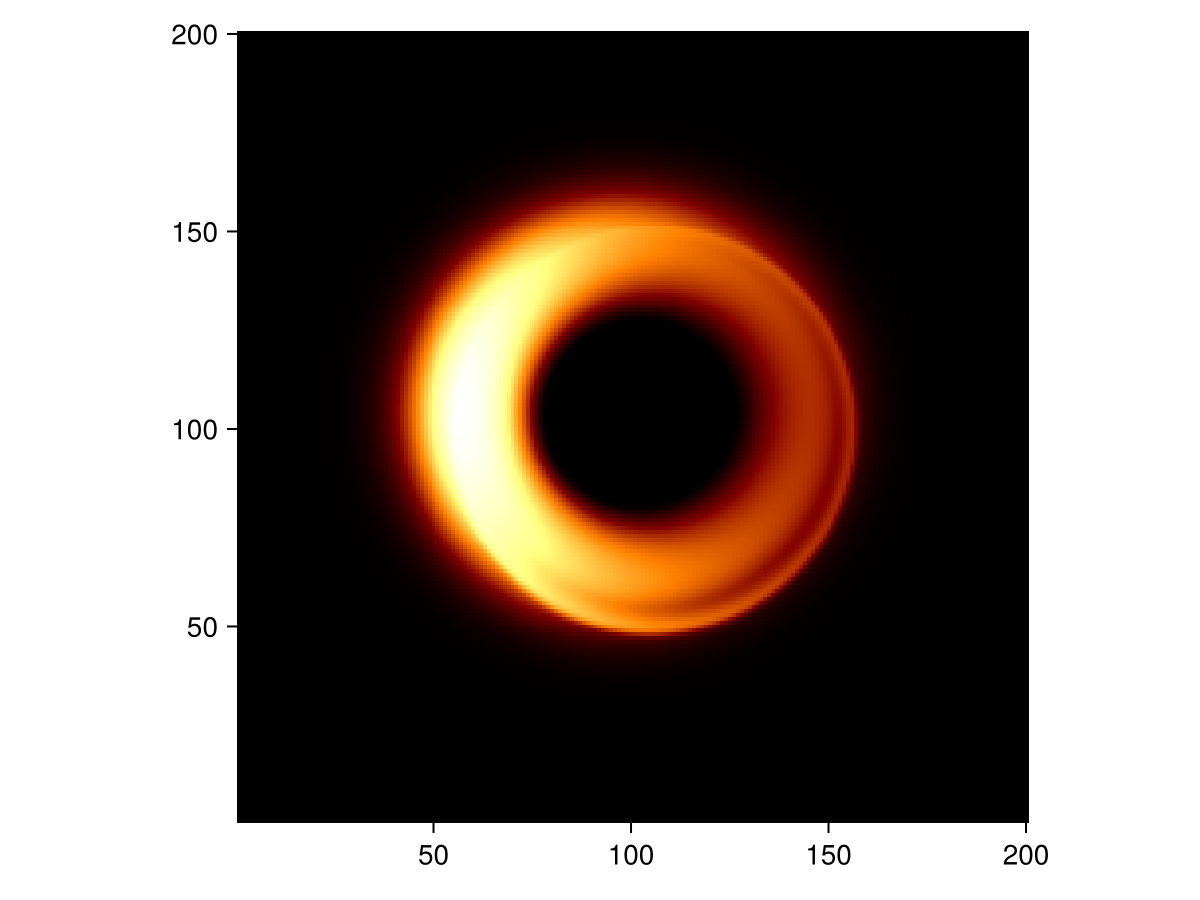

In [17]:
#90
fig = Figure();
ax = Axis(fig[1,1], aspect=1)  

mesh1 = Krang.Mesh(Krang.ConeGeometry(π/2), mat)
#mesh2 = Krang.Mesh(Krang.ConeGeometry(3π/4), mat)
intersections = render(cam, Krang.Scene((mesh1, )))

# And plot the image with GLMakie, 

heatmap!(ax, intersections, colormap=:afmhot);
fig

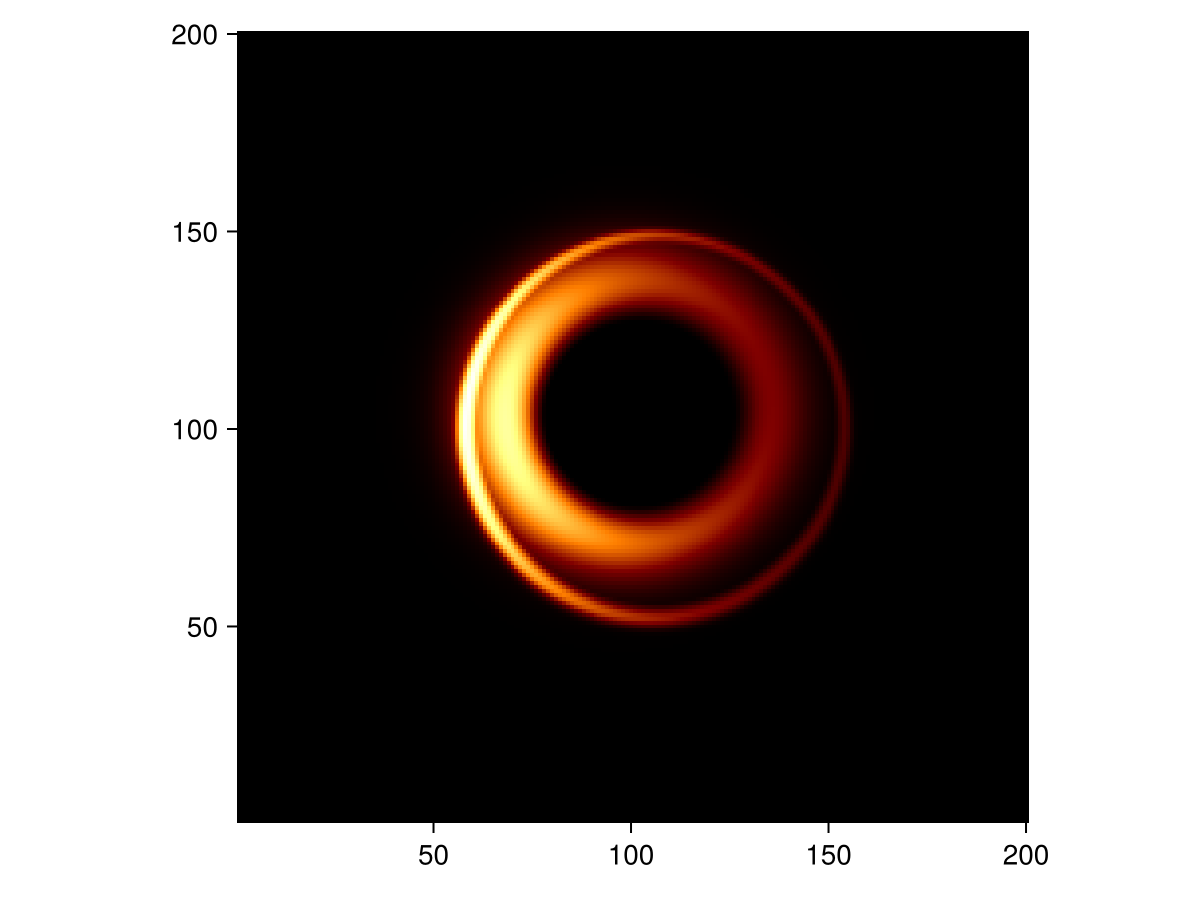

In [254]:
#230 
fig = Figure();
ax = Axis(fig[1,1], aspect=1)  

mesh1 = Krang.Mesh(Krang.ConeGeometry(π/2), mat)
intersections = render(cam, Krang.Scene((mesh1, )))

# And plot the image with GLMakie, 

heatmap!(ax, intersections, colormap=:afmhot);
fig


In [218]:
intersections

10×10 Matrix{Float64}:
 0.370779  0.365072  0.359402  0.353113  …  0.318009  0.313114  0.311354
 0.35961   0.354928  0.351569  0.348814     0.303018  0.295647  0.293567
 0.348716  0.346508  0.350567  0.367148     0.297514  0.280629  0.276563
 0.337915  0.339969  0.3638    0.531861     0.332372  0.271945  0.261632
 0.326613  0.333007  0.391369  0.0          0.534696  0.270606  0.249399
 0.314247  0.320824  0.389205  0.0       …  0.690113  0.265141  0.23896
 0.301273  0.302744  0.338874  0.766846     0.37429   0.247382  0.22945
 0.28923   0.284473  0.292475  0.338767     0.264365  0.228954  0.221776
 0.279544  0.270637  0.265785  0.267596     0.227888  0.21794   0.217123
 0.272728  0.261965  0.252617  0.245083     0.216178  0.213731  0.215562

In [19]:
2c/c

2